# 08-04 - Eigendecompositions and Laplacian Eigenmaps

*June 14 2023*  

Both the eigendecomposition and the SVD-based embedding minimize loss functions that are based on the dot product of vector space representations of nodes. We now show how we can use eigenvectors of the Laplacian matrix to learn low-dimensional representations of complex networks, which minimizes a loss function that is based on the Euclidean distance between node positions in the vector space. 

In [1]:
import scipy as sp
import numpy as np

from numpy import linalg as npl
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.linalg import eig
import pandas as pd
import pathpyG as pp

import seaborn as sns

plt.style.use('default')
sns.set_style("whitegrid")

In [2]:
g = pp.Graph.from_edge_list([
    ('a', 'b'),
    ('b', 'c'),
    ('a', 'c'),
    ('b', 'd'),
    ('d', 'f'),
    ('d', 'g'),
    ('d', 'e'),
    ('e', 'f'),
    ('f', 'g')]
    ).to_undirected()

pp.plot(g) #,node_label = g.mapping.node_ids)


In [3]:
def plot_embedding(network, embedding, figsize=[4,8], edgewidth=1, pointsize = 50, node_labels=True):
    """Function that plots a network in matplotlib, where nodes are assigned coordinates based on the embedding"""
    
    p_x = [embedding[x][0] for x in embedding]
    p_y = [embedding[x][1] for x in embedding]

    fig, ax = plt.subplots()
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    ax.scatter(p_x, p_y, s=pointsize)
    ax.set_xlabel(r'$v_1$', fontsize=14)
    ax.set_ylabel(r'$v_2$', fontsize=14)

    for v,w in network.edges:
        ax.annotate("", xy=(embedding[v][0], embedding[v][1]), xytext=(embedding[w][0], embedding[w][1]), arrowprops=dict(arrowstyle='-', color='gray', linewidth=edgewidth))

    if node_labels:
        for v in network.nodes:
            ax.annotate(v, (embedding[v][0]+0.01, embedding[v][1]+0.01), fontsize=20)




In [4]:

def laplacian_embedding(network, d=None, normalization = None):
    """Function that returns a vector representation of all nodes based on the entries of eigenvectors of the laplacian"""
    
    if d is None:
        d = network.N - 1
    ew, ev = sp.linalg.eig(network.get_laplacian(normalization=normalization).todense())

    # indices of non-zero eigenvalues
    nonzero_indices = np.where(~np.isclose(ew, 0, atol=1e-5))[0]

    # select eigenvectors and eigenvalues corresponding to non-zero eigenvalues
    ev = ev[:, nonzero_indices]
    ew = ew[nonzero_indices]

    # Sort eigenvalues and eigenvectors according to eigenvalue magnitude
    sort_indices = np.argsort(ew)
    ew = ew[sort_indices]
    ev = ev[:, sort_indices]

    vecs = {}
    for v in network.nodes:
        # Embedding x_ of node i in d-dimensional vector space is given by 
        # i-th component in the first d eigenvectors 
        vecs[v] = ev[network.mapping.id_to_idx[v], :d].real

    return vecs


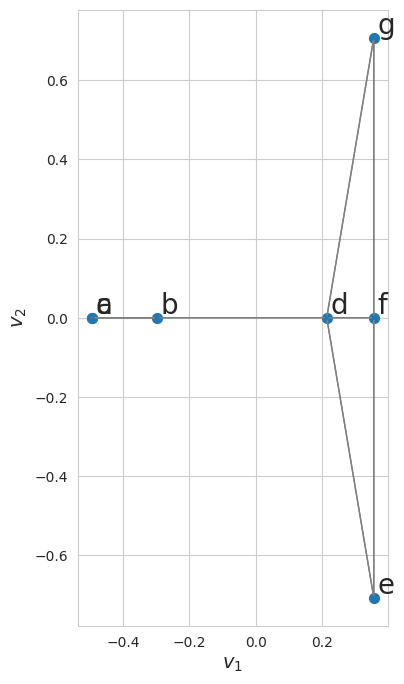

In [5]:
plot_embedding(g, laplacian_embedding(g))

### Generate lattice network... 

In [6]:
import torch
from torch_geometric.data import Data

def create_grid(rows, cols):
    """
    This function creates a grid network with the specified number of rows and columns.
    It returns an edge index tensor where each column represents an edge, and each row represents the source and target nodes of that edge.
    """
    edge_index = [[], []]
    for i in range(rows):
        for j in range(cols):
            node = i * cols + j  # node id
            if i > 0:
                edge_index[0].append(node)  #  top node
                edge_index[1].append((i - 1) * cols + j)
            if i < rows - 1:
                edge_index[0].append(node)  #  bottom node
                edge_index[1].append((i + 1) * cols + j)
            if j > 0:
                edge_index[0].append(node)  #  left node
                edge_index[1].append(i * cols + (j - 1))
            if j < cols - 1:
                edge_index[0].append(node)  #  right node
                edge_index[1].append(i * cols + (j + 1))

    edge_index_tensor = torch.tensor(edge_index, dtype=torch.int64)
    return pp.Graph(Data(edge_index = edge_index_tensor), mapping = pp.IndexMap(list(range(rows*cols))))


In [7]:
n = create_grid(5,5)
pp.plot(n)

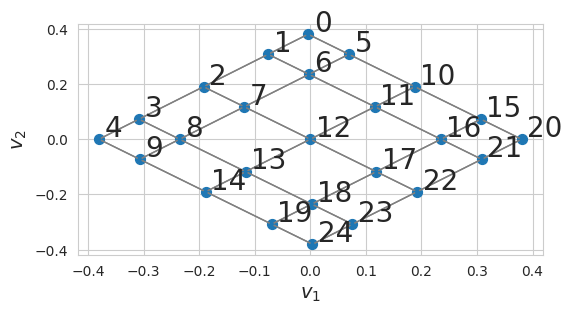

In [8]:
embedding = laplacian_embedding(n)
plot_embedding(n, embedding, figsize=[6,3])

In [9]:
max_node = 20
edgelist = []
for i in range(0,max_node):
    edgelist.append((str(i),str((i+1)%max_node)))
g = pp.Graph.from_edge_list(edgelist).to_undirected()
pp.plot(g) #,node_label = g.mapping.node_ids)

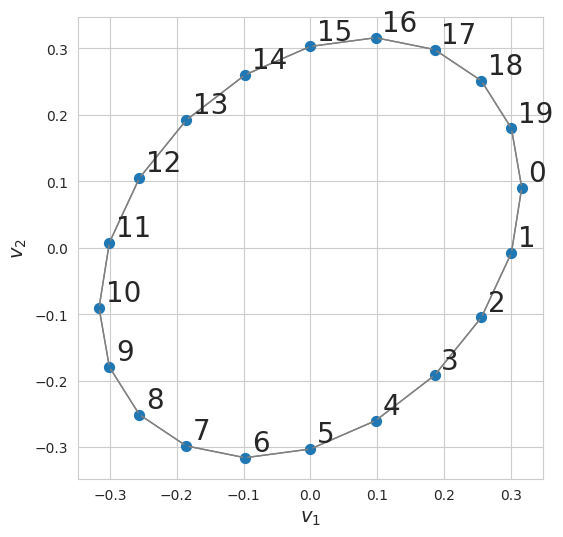

In [10]:
embedding = laplacian_embedding(g)
plot_embedding(g, embedding, figsize=[6,6])

In [11]:
import torch
from itertools import product

def create_lattice(*dimensions):
    """
    Create a lattice network with the specified dimensions.

    Args:
        *dimensions: Variable number of arguments representing the size of each dimension in the lattice.

    Returns:
        pp.Graph: A lattice network represented as a graph.

    Example:
        For a 2x3x4 lattice:
        - create_lattice(2, 3, 4) returns a lattice network graph.
    """
    edge_index = [[], []]
    def node_index(*coords):
        """
        Calculate the index of a node in a grid or lattice given its coordinates in each dimension.

        Args:
            *coords: Variable number of arguments representing the coordinates of the node along each dimension.

        Returns:
            int: The index of the node in the grid or lattice.

        Example:
            For a 2D grid with dimensions (3, 4):
            - node_index(1, 2) returns 6, representing the index of the node at coordinates (1, 2).
            - node_index(0, 0) returns 0, representing the index of the node at coordinates (0, 0).
        """
        index = 0
        multiplier = 1
        for dim, coord in zip(dimensions, coords):
            index += coord * multiplier
            multiplier *= dim
        return index

    for coord in product(*[range(dim) for dim in dimensions]): # all nodes coordinates
        node = node_index(*coord)
        for dim, val in enumerate(coord):
            if val > 0: #lower border condition
                neighbor_coord = list(coord)
                neighbor_coord[dim] -= 1 # moving to down-neighbor
                neighbor = node_index(*neighbor_coord)
                edge_index[0].append(node)
                edge_index[1].append(neighbor)

            if val < dimensions[dim] - 1: # higher border condition
                neighbor_coord = list(coord)
                neighbor_coord[dim] += 1 # moving to up-neighbor
                neighbor = node_index(*neighbor_coord)
                edge_index[0].append(node)
                edge_index[1].append(neighbor)

    edge_index_tensor = torch.tensor(edge_index, dtype=torch.int64)
    return pp.Graph(Data(edge_index=edge_index_tensor), mapping=pp.IndexMap(range(edge_index_tensor.max() + 1)))


In [12]:
cube_lattice =create_lattice(5,5,5)
pp.plot(cube_lattice)

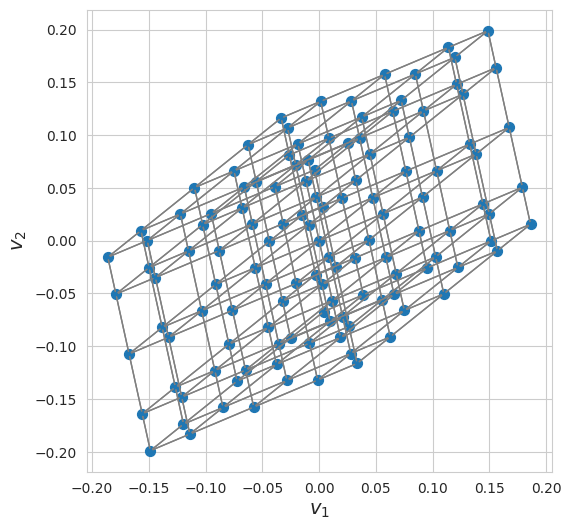

In [13]:
embedding = laplacian_embedding(cube_lattice)
plot_embedding(cube_lattice, embedding, node_labels=False, figsize=[6,6])

## Unsupervised Link prediction based on Laplacian Embedding

In [14]:

import torch
import torch_geometric as pyG
def random_geometric_net(n, dim, dist, rule, lcc=True, **kwargs):

    # generate empty graph and assign random node positions
    data = pyG.data.Data()
    
    nodes = []
    data.pos = torch.zeros((n,dim))
    for i in range(n):
        nodes.append(i)
        data.pos[i] = torch.tensor([np.random.random() for x in range(dim)])
    
    # compute node similarity and add edges
    sources = []
    targets = []
    for v in range(n):
        for w in range(v+1,n):
            if rule(dist(data.pos[v], data.pos[w]), **kwargs):
                sources.append(v)
                targets.append(w)
    data.edge_index = torch.tensor([sources,targets])
    if lcc:
        lcc_transform = pyG.transforms.LargestConnectedComponents()
        data = lcc_transform(data)
    g = pp.Graph(data)
    g.mapping = pp.IndexMap(list(range(n)))
    return g.to_undirected()

def euclidean_dist(x, y):
    return np.linalg.norm(x-y)

def hard_rule(dist, **kwargs):
    if dist < kwargs['threshold']:
        return True
    else:
        return False

def soft_rule(dist, **kwargs):
    p = kwargs['beta'] * np.exp(-dist/kwargs['alpha'])
    if np.random.random() <= p:
        return True
    else:
        return False

def euclidean_sim(x, y):
    return -euclidean_dist(x, y)

def cosine_sim(x, y):
    return x.dot(y)    



import torch
from sklearn.model_selection import train_test_split

def generate_link_prediction_datasets(g, test_ratio=0.3, add_self_loops=True):
    """
    Generates link unsupervised prediction datasets from the input graph.
    Thas is, we get a dataset with edge_index we can use for training, 
    and y_index and y keys for indexes of test edges (both positive and negative samples) 
    and labels (as positive or negative sample) respectively

    Args:
        g (ppG.graph): The input graph data object.
        test_ratio (float): The fraction of edges to be used for the test set.

    Returns:
        - link_prediction_data (torch_geometric.data.Data): A ppG graph object
    """
    def add_edge_index_self_loops(edge_index, num_nodes):
        # useful to avoid truobles from pyG imposing contiguous edge indices
        all_nodes = set(range(num_nodes))
        unique_nodes = set(edge_index[0].tolist()) | set(edge_index[1].tolist())
        isolated_nodes = torch.tensor(list(all_nodes - unique_nodes)).long()
        isolated_self_loops = torch.stack([isolated_nodes, isolated_nodes], dim=0)
        edge_index = torch.cat([edge_index, isolated_self_loops], dim=1)
        return edge_index

    negative_sample = pyG.utils.negative_sampling(g.data.edge_index, num_neg_samples = int(g.M*test_ratio))

    edges =  g.data.edge_index.t().tolist()
    train_edges, test_edges = train_test_split(edges, test_size=test_ratio)

    positive_sample = torch.tensor(test_edges).t()

    train_edge_index = torch.tensor(train_edges).t()
    y_index = torch.cat((positive_sample, negative_sample), dim=1)
    y = torch.cat((torch.ones(positive_sample.shape[1]), torch.zeros(negative_sample.shape[1])), dim=0)

    data = pyG.data.Data(
        edge_index=train_edge_index,
        y_index=y_index,
        y=y,
        pos=g.data.pos,
        num_nodes = g.N
    )

    if add_self_loops:
        data.edge_index = add_edge_index_self_loops(data.edge_index, data.num_nodes)

    return data



def assign_sim(data, sim_score):
    # notice how the similarity is computed on the node couples that will be used for testing
    v_pos = data.pos[data.y_index[0]]
    w_pos = data.pos[data.y_index[1]]
    data.sim = torch.tensor([sim_score(v, w) for v, w in zip(v_pos, w_pos)])
    return data

def compute_ROC(data, plot=True):
    fpr, tpr, thresholds = metrics.roc_curve(data.y, data.sim)
    if plot:
        plt.plot(fpr, tpr)
        plt.plot(np.linspace(0,1), np.linspace(0,1), ls='--', c='r', alpha=0.5)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.tight_layout()
    auc = metrics.auc(fpr, tpr)
    return auc

In [15]:
g = random_geometric_net(n=100, dim=2, dist=euclidean_dist, rule=soft_rule, pos=None, alpha=0.03, beta=70)
pp.plot(
    g,
    # node_label = g.mapping.node_ids,
    layout = dict(zip([int(i) for i in g.nodes], g.data.pos.tolist()))
    )


In [16]:
link_prediction_data = generate_link_prediction_datasets(g)
link_prediction_data.pos = g.data.pos
train_network = pp.Graph(link_prediction_data)
train_network.mapping = g.mapping

In [17]:
embedding = laplacian_embedding(train_network, d=2)

np.float64(0.9965090158460325)

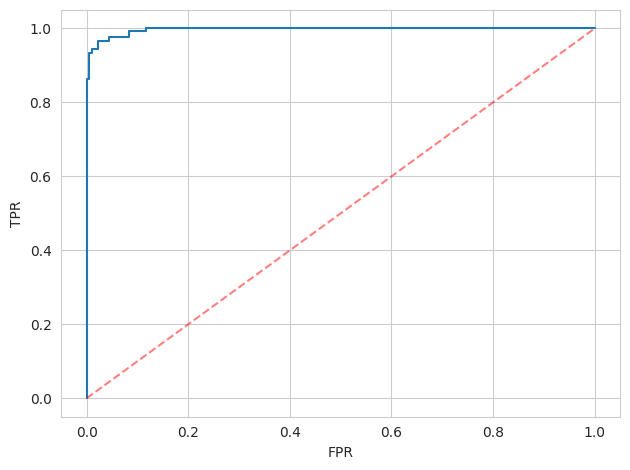

In [18]:
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)
compute_ROC(link_prediction_data)


In [19]:
   

def AUC_dim(
        n=100,
        threshold=0.5,
        data_dim=2,
        embedding=laplacian_embedding, 
        max_dim=10,
        samples=10):
    # 1.) generate network 
    n = random_geometric_net(n=n, dist=euclidean_dist, rule=lambda x: True if x < threshold else False, dim=data_dim, lcc=True)

    aucs = []
    for d in range(1, max_dim):
        print('Computing AUC for embedding in {0}-dimensional space'.format(d))
        # 2.) train and test set 
        mean_auc = 0        
        for i in range(samples):
            link_prediction_data = generate_link_prediction_datasets(n)
            train_network = pp.Graph(link_prediction_data)
            train_network.mapping = n.mapping
            vecs=embedding(train_network, d=d)
            # vecs = train_network.get_sparse_adj_matrix().todense()[:,:d]
            link_prediction_data.pos = torch.tensor([
            vecs[train_network.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] ) 

            # NB: IF I ASSIGN IT GET AND ERROR
            assign_sim(link_prediction_data,  euclidean_sim)
            mean_auc += compute_ROC(link_prediction_data, plot=False)
        mean_auc = mean_auc / samples
        aucs.append(mean_auc)
    return aucs 

Computing AUC for embedding in 1-dimensional space


/tmp/ipykernel_21/3863269269.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  link_prediction_data.pos = torch.tensor([


Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


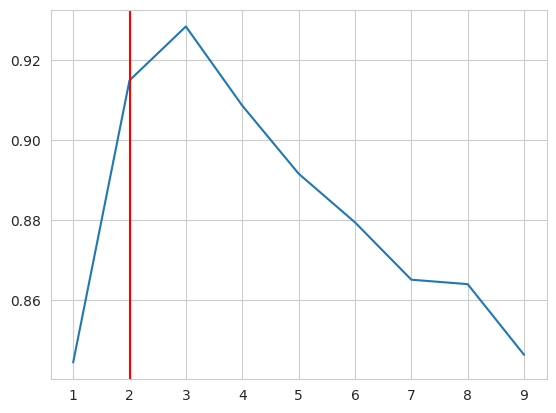

In [20]:
aucs = AUC_dim(data_dim=2, threshold=0.5)
plt.plot(range(1, 10), aucs)
plt.axvline(x=2, color='red');

Computing AUC for embedding in 1-dimensional space
Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


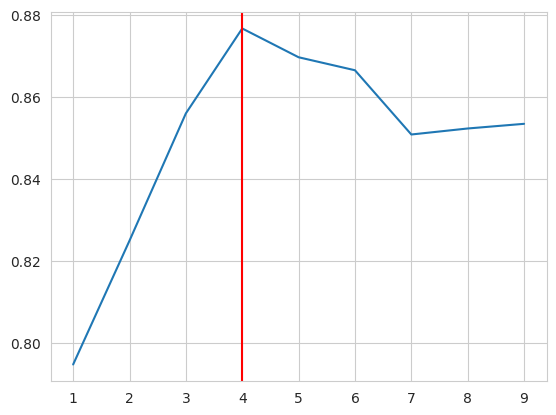

In [21]:
aucs = AUC_dim(data_dim=4, threshold=0.5)
plt.plot(range(1, 10), aucs)
plt.axvline(x=4, color='red');

## Embedding in Empirical Network and Normalized Laplacian

In [22]:
empirical = pp.io.read_netzschleuder_network("polbooks") # other networks don t seem to work
empirical.mapping = pp.IndexMap(range(empirical.N))
# pp.plot(empirical)

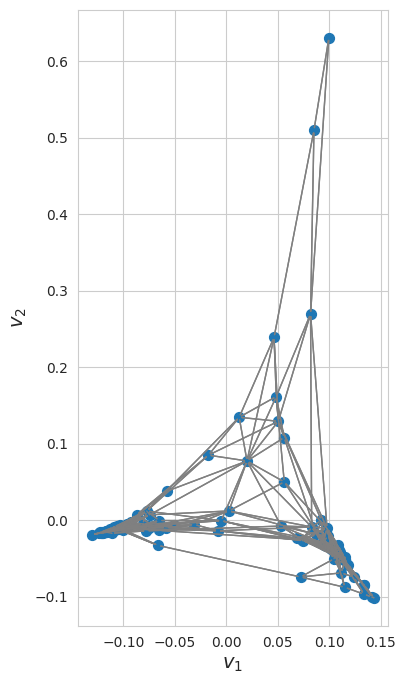

In [23]:
embedding = laplacian_embedding(empirical)
plot_embedding(empirical, embedding, node_labels=False)

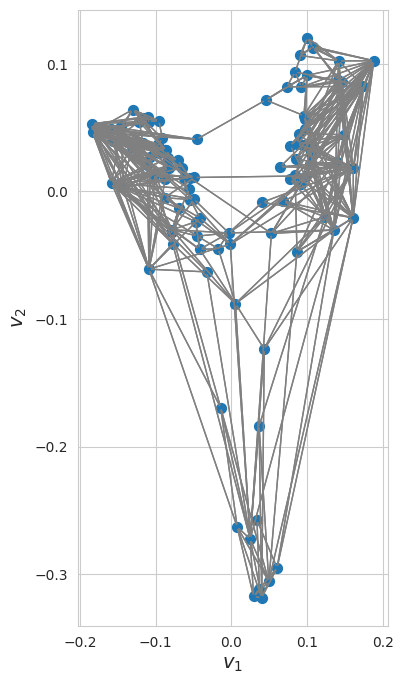

In [24]:
embedding_normalized = laplacian_embedding(empirical, d=2, normalization="sym")
plot_embedding(empirical, embedding_normalized, node_labels=False)

In [25]:
# fixing the split
link_prediction_data = generate_link_prediction_datasets(empirical)
train_network = pp.Graph(link_prediction_data)
train_network.mapping = empirical.mapping

np.float64(0.7839336763865065)

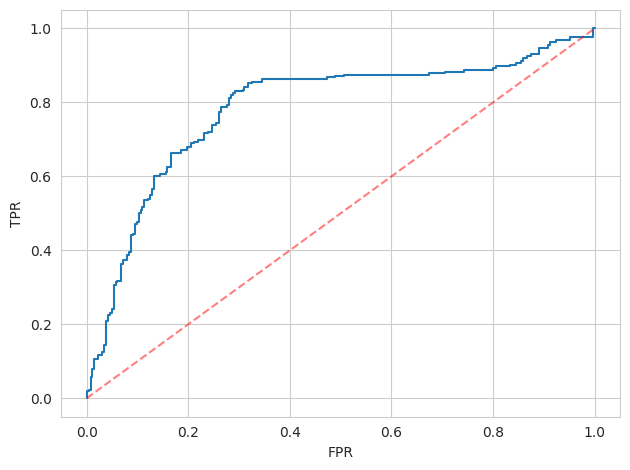

In [26]:
# computing embedding and assigning sim
embedding = laplacian_embedding(train_network, d=5)
link_prediction_data.pos = torch.tensor([
        embedding[train_network.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] ) 
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)

compute_ROC(link_prediction_data)



np.float64(0.8082046883933676)

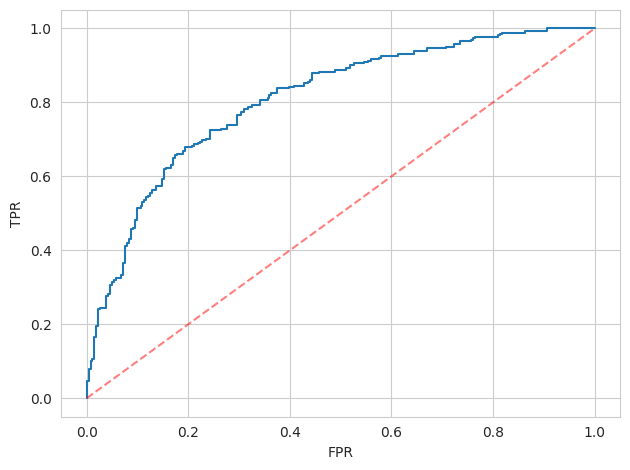

In [27]:
# computing embedding and assigning sim
embedding = laplacian_embedding(train_network, d=5,normalization="sym")
link_prediction_data.pos = torch.tensor([
        embedding[train_network.mapping.to_ids(node_idx)] for node_idx in range(train_network.N)] ) 
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)
compute_ROC(link_prediction_data)